# Animation

In [65]:
from summit.strategies import SOBO, Chimera, MultitoSingleObjective
from summit.benchmarks import SnarBenchmark, DTLZ2
from summit.utils.multiobjective import pareto_efficient
from summit import Runner
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar as colorbar
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
from pandas.plotting import parallel_coordinates
import io
import cv2

# Video recording
from pyrecorder.recorders.gif import GIF
from pyrecorder.converter import Converter
from pyrecorder.video import Video

In [142]:
# Instantiate the benchmark
exp = SnarBenchmark()

# Since the Snar benchmark has two objectives and Nelder-Mead is single objective, we need a multi-to-single objective transform
transform = MultitoSingleObjective(
    exp.domain, expression="-sty/1e4+e_factor/100", maximize=False
)

# Set up the strategy, passing in the optimisation domain and transform
strategy = SOBO(exp.domain, transform=transform)

# Use the runner to run closed loop experiments
r = Runner(
    strategy=strategy, experiment=exp,max_iterations=100)
r.run()

In [143]:
COLORS = [
    (165, 0, 38),
    (215, 48, 39),
    (244, 109, 67),
    (253, 174, 97),
    (254, 224, 144),
    (255, 255, 191),
    (224, 243, 248),
    (171, 217, 233),
    (116, 173, 209),
    (69, 117, 180),
    (49, 54, 149),
]
COLORS = np.array(COLORS) / 256
CMAP = ListedColormap(COLORS)


def parallel_plot(data, ax: plt.axes=None):
    labels = [
        "Conc. 4",
        "Equiv. 5",
        "Temperature",
        r"$\tau$",
        "E-factor",
        "STY",
    ]
    columns = [
        "conc_dfnb",
        "equiv_pldn",
        "temperature",
        "tau",
        "e_factor",
        "sty",
    ]
    data = data[columns]

    # Standardize data
    mins = data.min().to_numpy()
    maxs = data.max().to_numpy()
    data_std = (data - mins) / (maxs - mins)
    data_std["experiments"] = np.arange(1, data_std.shape[0] + 1)

    # Creat plot
    if ax is not None:
        fig = None
    else:
        fig, ax = plt.subplots(1, figsize=(10, 5))

    # color map
    new_colors = np.flip(COLORS, axis=0)
    new_cmap = ListedColormap(new_colors[5:])

    # Plot data
    parallel_coordinates(
        data_std,
        "experiments",
        cols=columns,
        colormap=new_cmap,
        axvlines=False,
        alpha=0.4,
        ax=ax
    )

    # Format plot (colorbar, labels, etc.)
    bounds = np.linspace(1, data_std.shape[0] + 1, 6)
    bounds = bounds.astype(int)
    cax, _ = colorbar.make_axes(ax)
    cb = colorbar.ColorbarBase(
        cax,
        cmap=new_cmap,
        spacing="proportional",
        ticks=bounds,
        boundaries=bounds,
        label="Number of Experiments",
    )
#     title = r.strategy.__class__.__name__
#     ax.set_title(title)
    ax.set_xticklabels(labels)
    for side in ["left", "right", "top", "bottom"]:
        ax.spines[side].set_visible(False)
    ax.grid(alpha=0.5, axis="both")
    ax.tick_params(length=0, direction='in')
    ax.get_legend().remove()
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        
    if fig is None:
        return ax
    else:
        return fig, ax
    
def pareto_plot(domain, data, objectives=None, colorbar=False, ax=None, fig=None):
    """Make a 2D pareto plot of the experiments thus far

    Parameters
    ----------
    objectives: array-like, optional
        List of names of objectives to plot.
        By default picks the first two objectives
    ax: `matplotlib.pyplot.axes`, optional
        An existing axis to apply the plot to

    Returns
    -------
    if ax is None returns a tuple with the first component
    as the a new figure and the second component the axis

    if ax is a matplotlib axis, returns only the axis

    Raises
    ------
    ValueError
        If the number of objectives is not equal to two


    """
    if objectives is None:
        objectives = [v.name for v in domain.variables if v.is_objective]
        objectives = objectives[0:2]

    if len(objectives) != 2:
        raise ValueError("Can only plot 2 objectives")

    data = data.copy()
    data_original = data.copy()
    
    # Handle minimize objectives
    for objective in objectives:
        if not domain[objective].maximize:
            data[objective] = -1.0 * data[objective]

    values, indices = pareto_efficient(data[objectives].to_numpy(), maximize=True)

    return_fig = True
    if ax is None:
        fig, ax = plt.subplots(1)    
    elif fig is None:
        return_fig = False

    # Plot all data
    new_colors = np.flip(COLORS, axis=0)
    if len(data) > 0:
        strategies = pd.unique(data["strategy"])
        markers = ["o", "x"]
        for strategy, marker in zip(strategies, markers):
            strat_data = data_original[data_original["strategy"] == strategy]
            c = strat_data.index.values.astype(int) if colorbar else "k"
            cmap = ListedColormap(new_colors[5:])
            im = ax.scatter(
                strat_data[objectives[0]],
                strat_data[objectives[1]],
                cmap=cmap,
                c=c,
                alpha=1 if colorbar else 0.5,
                marker=marker,
                s=100,
                label=strategy,
            )

        # Sort data so get nice pareto plot
        pareto_data = data_original.iloc[indices].copy()
        pareto_data = pareto_data.sort_values(by=objectives[0])
        if len(pareto_data) > 2:
            ax.plot(
                pareto_data[objectives[0]],
                pareto_data[objectives[1]],
                c=(165 / 256, 0, 38 / 256),
                label="Pareto Front",
                linewidth=3,
            )
        ax.set_xlabel(objectives[0])
        ax.set_ylabel(objectives[1])
#         if return_fig and colorbar:
#             fig.colorbar(im)
        ax.tick_params(direction="in")
        ax.legend()

    return im
    

class Matplotlib(Converter):

    def __init__(self, dpi=100, close_after_recording=True) -> None:
        super().__init__()
        self.dpi = dpi
        self.close_after_recording = close_after_recording

    def do(self, fig=None, **kwargs):
        buf = io.BytesIO()

        if fig is None:
            plt.savefig(buf, format='png', dpi=self.dpi, bbox_inches='tight')
        else:
            fig.savefig(buf, format='png', dpi=self.dpi, bbox_inches='tight')

        buf.seek(0)
        _bytes = np.asarray(bytearray(buf.read()), dtype=np.uint8)
        img = cv2.imdecode(_bytes, cv2.IMREAD_COLOR)

        if self.close_after_recording:
            plt.close()

        return img
    
def make_plots(domain, data):
    fig, axes = plt.subplots(2,1, figsize=(10,8))
    fig.subplots_adjust(hspace=0.5)
    parallel_plot(data, ax=axes[0])
    im = pareto_plot(domain, data, ax=axes[1], colorbar=True)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes()
    fig.colorbar(im,cax=cbar_ax) 
    axes[1].set_xlabel(r"Space Time Yield ($kg \; m^{-3} h^{-1}$)")
    axes[1].set_ylabel("E-factor")
    return fig, axes

In [148]:
fname = "figures/parallel_plot.gif"
vid = Video(GIF(fname), converter=Matplotlib(dpi=100))
data = r.experiment.data
n_experiments = len(data)
n_frames = 1

for i in range(5,30):
    for _ in range(n_frames):
        parallel_plot(data.iloc[:i])
        vid.record()
    
vid.close()

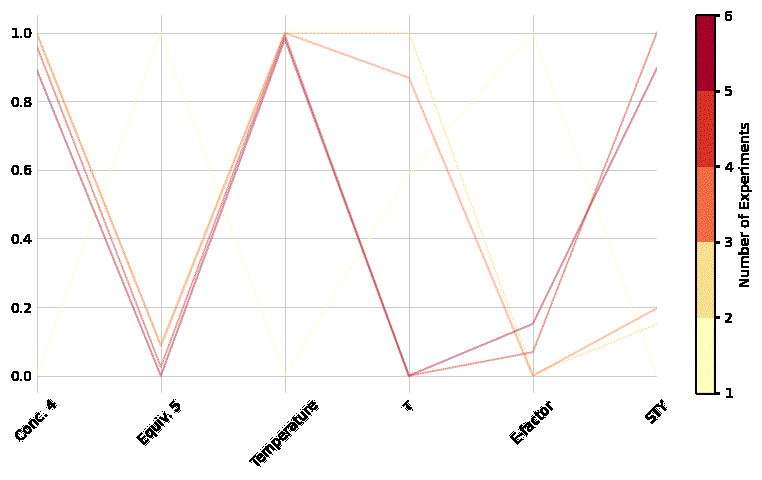

In [149]:
from pyrecorder.video import load
load("figures/parallel_plot.gif")